<a href="https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/main/GP15_Defining_Watermass_Subtypes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install py_pcha
!pip install gsw

Grab the data

In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr" -O GLODAPv2.2019_Pacific_Ocean.csv && rm -rf /tmp/cookies.txt

--2021-05-07 16:51:31--  https://docs.google.com/uc?export=download&confirm=bd6j&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr
Resolving docs.google.com (docs.google.com)... 108.177.119.113, 108.177.119.138, 108.177.119.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.119.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-0s-docs.googleusercontent.com/docs/securesc/hi2egnnd3abu2snibasihpclp9bf8973/g0d7s681hnvul1cs3sjmr8m9jq8ia90l/1620406275000/06203730782251856755/07692678939390924782Z/1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr?e=download [following]
--2021-05-07 16:51:32--  https://doc-0o-0s-docs.googleusercontent.com/docs/securesc/hi2egnnd3abu2snibasihpclp9bf8973/g0d7s681hnvul1cs3sjmr8m9jq8ia90l/1620406275000/06203730782251856755/07692678939390924782Z/1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr?e=download
Resolving doc-0o-0s-docs.googleusercontent.com (doc-0o-0s-docs.googleusercontent.com)... 108.177.119.132, 2a00:1450:4013:c00::84
Conne

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas
import gsw

Read in the data frame and pick a subset of columns

In [4]:
colnames_subset = ["latitude", 'longitude', 'year', 'depth',
                   'pressure', 'temperature','salinity','oxygen',
                   'silicate', 'nitrate', 'phosphate', 'sigma0']


df = pandas.read_csv("GLODAPv2.2019_Pacific_Ocean.csv",
                     na_values = -9999)[colnames_subset]

df['NO'] = df['oxygen'] + (df['nitrate']*9.68)
df['PO'] = df['oxygen'] + (df['phosphate']*155)
df['potential_temperature'] = gsw.pt_from_t(df['salinity'],
                                df['temperature'],
                                df['pressure'],
                                df['sigma0'])
df["absolute_salinity"] = gsw.SA_from_SP(
    SP=df["salinity"], p=df["pressure"],
    lon=df["longitude"], lat=df["latitude"])
df["conservative_temperature"] = gsw.CT_from_t(SA=df["absolute_salinity"],
                                  t=df["temperature"],
                                  p=df["pressure"])
df["sigma2"] = gsw.sigma2(SA=df["absolute_salinity"],CT=df["conservative_temperature"])
df["sigma4"] = gsw.sigma4(SA=df["absolute_salinity"],CT=df["conservative_temperature"])

In [5]:
#ARCH_ANALYSIS_FEATURES = ["conservative_temperature", "absolute_salinity",
#                          "silicate", "NO", "PO"]
ARCH_ANALYSIS_FEATURES = ["conservative_temperature", "absolute_salinity",
                          "silicate", "nitrate", "phosphate", "oxygen"]
ALL_FEATURES_TO_AVERAGE = ARCH_ANALYSIS_FEATURES#+["phosphate", "nitrate", "oxygen"]

#feature_weights = {"conservative_temperature": 56.0,
#                   "absolute_salinity": 80.0,
#                   "silicate": 3.0,
#                   "NO": 5.0,
#                   "PO": 5.0}
feature_weights = {"conservative_temperature": 5.0,
                   "absolute_salinity": 5.0,
                   "silicate": 1.0,
                   "NO": 1.0,
                   "PO": 1.0,
                   "nitrate": 1.0,
                   "phosphate": 1.0,
                   "oxygen": 1.0}

print("Standardizing feature values")
#Let's standardize each column by subtracting mean,
# dividing by standard deviation and multiplying by the feature weights.
# Call it a 'features' dataframe
#keep track of mean and std in order to do inverse transform
colname_to_mean = {}
colname_to_std = {} 
for colname in ARCH_ANALYSIS_FEATURES:
  vals = np.array(df[colname])
  #use nanmean and nanstd to ignore nan values for now
  mean = np.nanmean(vals)
  std = np.nanstd(vals)
  colname_to_mean[colname] = mean
  colname_to_std[colname] = std
  df['standardized_'+colname] = feature_weights[colname]*(vals-mean)/std

#Since imputation takes a while on such a large dataset, we
# will just drop rows that have missing values
print("Proportions of missing values:")
print(np.sum(np.isnan(df)) / len(df))
print("Original number of rows:", len(df))
df = df.dropna()
print("Remaining rows after dropping missing vals:",len(df))

TRANSFORM_MEANS = np.array([colname_to_mean[colname]
                           for colname in ARCH_ANALYSIS_FEATURES])
TRANSFORM_STDS = np.array([(colname_to_std[colname]/feature_weights[colname])
                           for colname in ARCH_ANALYSIS_FEATURES])


#function to map features back to original space
def map_features_back(features):
  return features*TRANSFORM_STDS[None,:] + TRANSFORM_MEANS[None,:]




Standardizing feature values
Proportions of missing values:
latitude                                 0.000000
longitude                                0.000000
year                                     0.000000
depth                                    0.001663
pressure                                 0.001663
temperature                              0.004228
salinity                                 0.011072
oxygen                                   0.096587
silicate                                 0.198236
nitrate                                  0.161553
phosphate                                0.175817
sigma0                                   0.013564
NO                                       0.183883
PO                                       0.196824
potential_temperature                    0.013672
absolute_salinity                        0.011072
conservative_temperature                 0.013407
sigma2                                   0.013407
sigma4                                  

On water mass AAIW
Ranges: {'lat_min': -51.0, 'lat_max': -47.0, 'lon_min': -120.0, 'lon_max': 150.0, 'sig0_min': 27.01, 'sig0_max': 27.1}


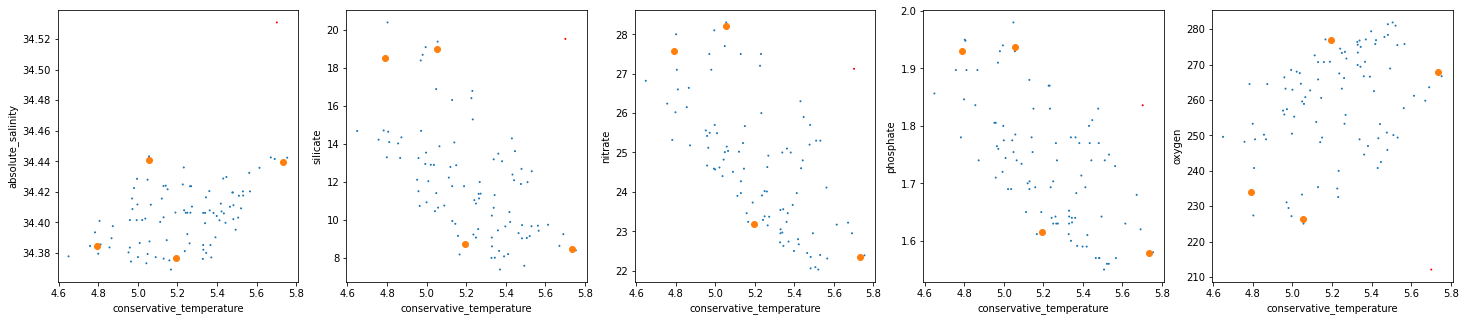

,conservative_temperature,absolute_salinity,silicate,nitrate,phosphate,oxygen
0,5.734319,34.439464,8.479963,22.358734,1.578263,267.941936
1,5.054960,34.440719,18.988861,28.203092,1.938076,226.424416
2,5.194408,34.376699,8.740828,23.187886,1.614517,277.009136
3,4.791026,34.384745,18.504495,27.586313,1.929998,234.118614


On water mass NPIW
Ranges: {'lat_min': 36.0, 'lat_max': 40.0, 'lon_min': 150.0, 'lon_max': 170.0, 'sig0_min': 26.6, 'sig0_max': 27.0, 'ox_min': 0, 'ox_max': 150.0}


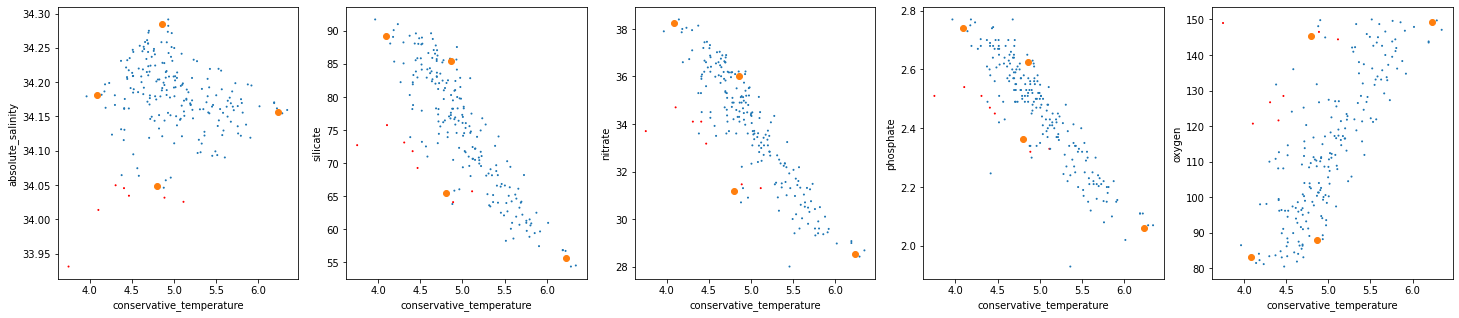

,conservative_temperature,absolute_salinity,silicate,nitrate,phosphate,oxygen
0,4.799847,34.048959,65.449186,31.164341,2.364018,145.474074
1,4.861819,34.284321,85.499949,36.003550,2.626585,87.963525
2,4.086553,34.180868,89.208781,38.243677,2.742506,83.063230
3,6.234109,34.156789,55.737498,28.542183,2.059831,149.252986


On water mass UCDW
Ranges: {'lat_min': -50.0, 'lat_max': -45.0, 'lon_min': -120.0, 'lon_max': 150.0, 'sig2_min': 36.96, 'sig2_max': 200, 'sig4_min': 0, 'sig4_max': 45.84}


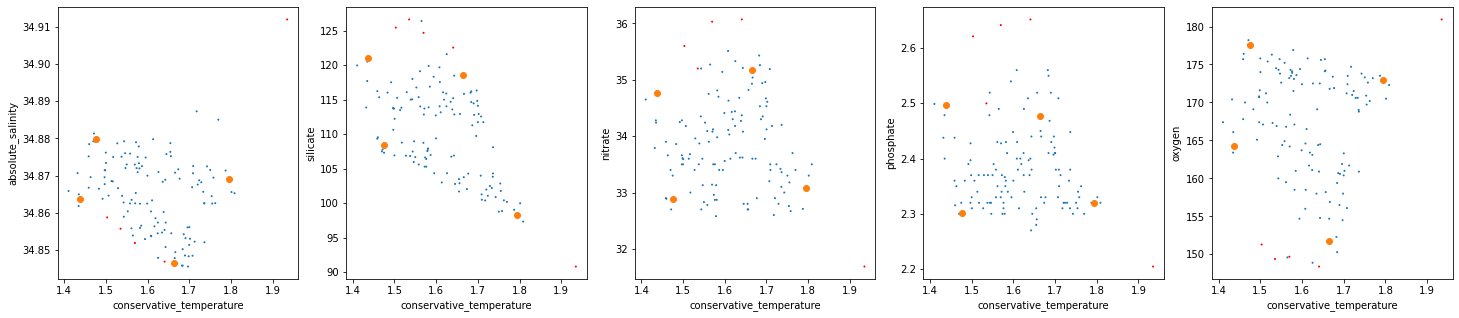

,conservative_temperature,absolute_salinity,silicate,nitrate,phosphate,oxygen
0,1.475990,34.879958,108.482140,32.880064,2.301547,177.502187
1,1.437226,34.863825,121.110512,34.757541,2.497439,164.312521
2,1.794446,34.869164,98.296761,33.080312,2.319578,172.990740
3,1.664558,34.846661,118.557574,35.181007,2.477510,151.817621


On water mass LCDW
Ranges: {'lat_min': -64.0, 'lat_max': -58.0, 'lon_min': -120.0, 'lon_max': 150.0, 'sig4_min': 45.84, 'sig4_max': 46.04}


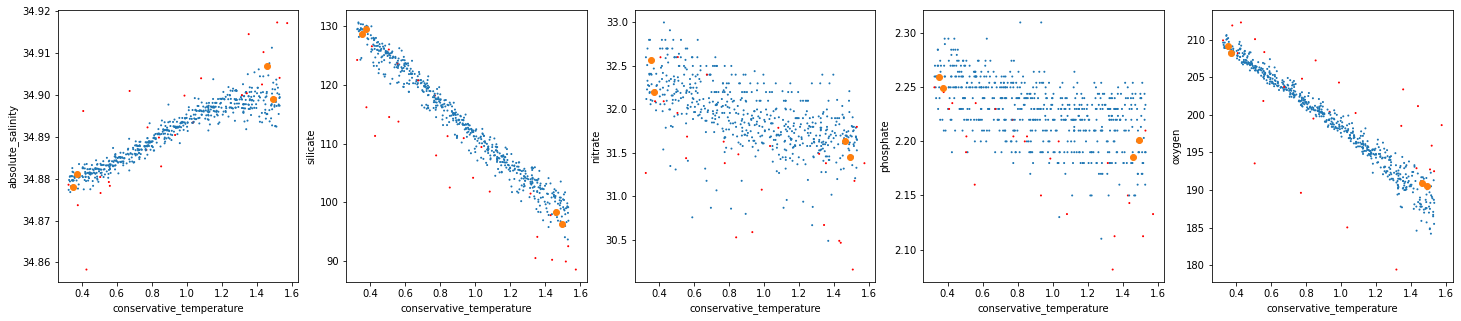

,conservative_temperature,absolute_salinity,silicate,nitrate,phosphate,oxygen
0,1.492463,34.899044,96.256745,31.449727,2.200879,190.564494
1,0.352263,34.877942,128.767841,32.567585,2.259557,209.115294
2,1.460094,34.906956,98.449111,31.635479,2.185866,190.920676
3,0.371945,34.881086,129.565616,32.201922,2.249362,208.164281


On water mass AABW
Ranges: {'lat_min': -60.0, 'lat_max': -50.0, 'lon_min': -120.0, 'lon_max': 150.0, 'sig4_min': 46.04, 'sig4_max': 200}


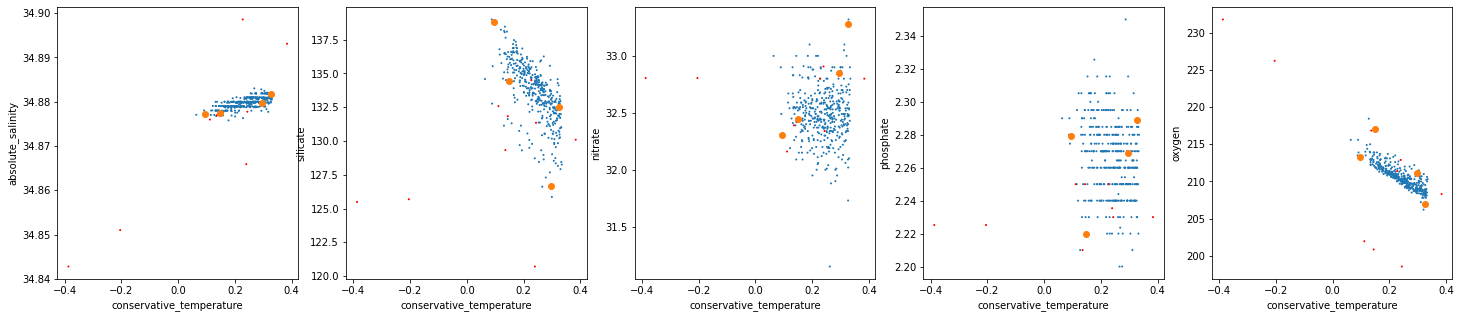

,conservative_temperature,absolute_salinity,silicate,nitrate,phosphate,oxygen
0,0.296130,34.879809,126.705323,32.845491,2.269185,211.117833
1,0.326383,34.881818,132.526927,33.280235,2.288781,206.896571
2,0.148294,34.877527,134.463146,32.448433,2.219714,217.023064
3,0.094884,34.877167,138.783874,32.303077,2.279259,213.344174


On water mass PDW1
Ranges: {'lat_min': 39.0, 'lat_max': 51.0, 'lon_min': -170.0, 'lon_max': -133.0, 'sig0_min': 27.6, 'sig0_max': 200, 'sig2_min': 0, 'sig2_max': 36.96}


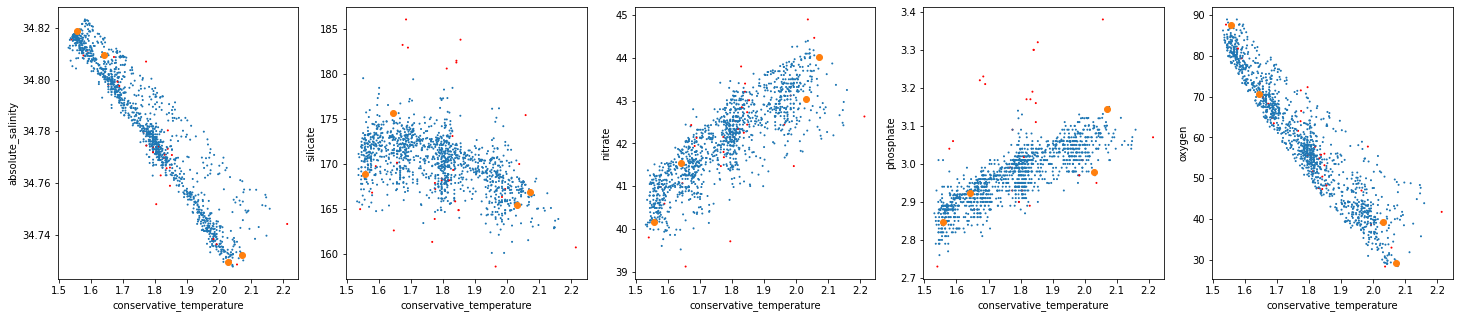

,conservative_temperature,absolute_salinity,silicate,nitrate,phosphate,oxygen
0,1.556965,34.819003,168.879388,40.159896,2.847689,87.419027
1,2.071307,34.731996,166.894270,44.015929,3.145062,29.216825
2,1.642022,34.809436,175.635165,41.548258,2.922254,70.728690
3,2.030314,34.729458,165.449494,43.045589,2.979874,39.196184


On water mass PDW2-3
Ranges: {'lat_min': 39.0, 'lat_max': 51.0, 'lon_min': -170.0, 'lon_max': -133.0, 'sig2_min': 36.96, 'sig2_max': 200, 'sig4_min': 0, 'sig4_max': 45.88}


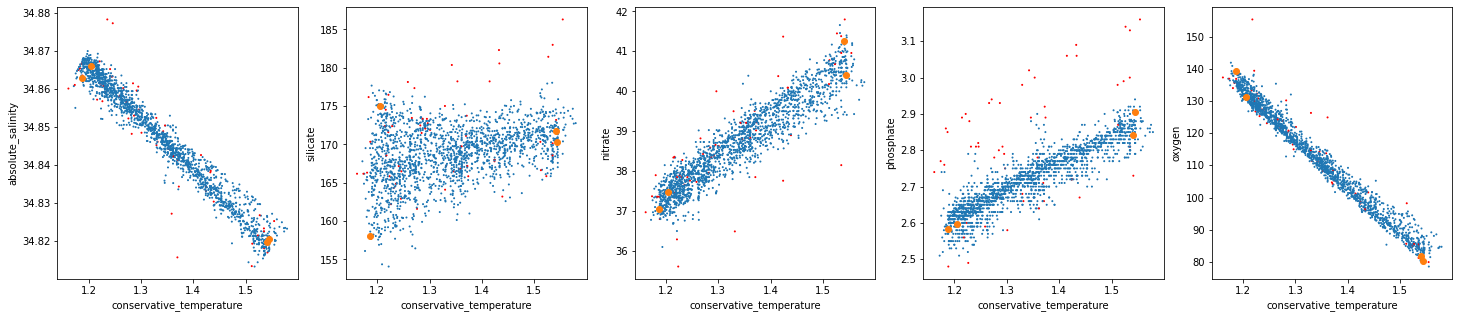

,conservative_temperature,absolute_salinity,silicate,nitrate,phosphate,oxygen
0,1.205134,34.866088,175.000835,37.486559,2.597423,131.210958
1,1.544040,34.820447,170.372210,40.415240,2.905023,80.351036
2,1.187070,34.862755,158.057062,37.045717,2.583389,139.374403
3,1.540656,34.819697,171.794696,41.250239,2.841378,81.862814


In [14]:
from py_pcha import PCHA
import scipy 
from scipy import spatial
from IPython.display import display, HTML


def flag_outliers(features, n_neighbors=20, zscore_threshold=2):
    #Features is observations X features
    #Do a process of removing outliers; if the average distance of a point to
    # its nearest N neighbors is more than stdev number of standard deviations from
    # the mean, flag it as an outlier.
    #I tried the Extreme Studentized Deviate but it wasn't behaving very
    # predictably. I guess the distribution of neighbor distances is
    # exponential-ish rather than normal.
    pairwise_distances = scipy.spatial.distance.squareform(
        scipy.spatial.distance.pdist(X=features, metric="euclidean"))
    avg_dist_to_nn = np.mean(
        np.sort(pairwise_distances, axis=-1)[:,1:n_neighbors+1], axis=-1)
    zscore_avgdisttonn = (avg_dist_to_nn - np.mean(avg_dist_to_nn))/np.std(
                          avg_dist_to_nn)
    #plt.hist(zscore_avgdisttonn, bins=100)
    #plt.show()
    anomalous_indices = np.abs(zscore_avgdisttonn) > zscore_threshold
    return anomalous_indices


def run_archetype_analysis(df, num_endmembers):
    all_features = np.array([np.array(df["standardized_"+col])
                      for col in ARCH_ANALYSIS_FEATURES]).transpose((1,0))
    all_origspace_features = np.array([np.array(df[col]) for col in
                                   ALL_FEATURES_TO_AVERAGE]).transpose((1,0))

    outliers = flag_outliers(all_features)
    features = all_features[outliers==False]
    origspace_features = all_origspace_features[outliers==False]

    XC, S, C, SSE, varexpl = PCHA(X=features.T, noc=num_endmembers,
                                  verbose=False)
    archetype_features = np.array(XC).T #becomes archtetypes X features
    obs_combos_giving_archetypes = np.array(C).T #archetypes X obs combos

    origspace_archetypes = obs_combos_giving_archetypes@origspace_features

    #Make scatterplots
    fig,ax = plt.subplots(nrows=1, ncols=len(ARCH_ANALYSIS_FEATURES)-1,
                          figsize=(25,5))
    pltnum = 0
    for featureidx1 in [0]:#range(len(ALL_FEATURES_TO_AVERAGE)):
        for featureidx2 in range(featureidx1+1, len(ALL_FEATURES_TO_AVERAGE)):
            if ((ALL_FEATURES_TO_AVERAGE[featureidx1]
                 in ARCH_ANALYSIS_FEATURES) and
                (ALL_FEATURES_TO_AVERAGE[featureidx2]
                 in ARCH_ANALYSIS_FEATURES)):
                plt.sca(ax[pltnum])
                plt.scatter(all_origspace_features[:,featureidx1],
                            all_origspace_features[:,featureidx2],
                            c=[("red" if x==True else "C0") for x in outliers],
                            s=1)
                plt.scatter(origspace_archetypes[:,featureidx1],
                            origspace_archetypes[:,featureidx2],
                            color="C1")
                plt.xlabel(ALL_FEATURES_TO_AVERAGE[featureidx1])
                plt.ylabel(ALL_FEATURES_TO_AVERAGE[featureidx2]) 
                pltnum += 1
    plt.show()

    return pandas.DataFrame(dict([(colname, origspace_archetypes[:,idx])
                        for idx,colname in enumerate(ALL_FEATURES_TO_AVERAGE)]))
    

filter_conditions = {
    "AAIW": {"lat_min":-51.0, "lat_max":-47.0,
             "lon_min":-120.0, "lon_max":150.0,
             "sig0_min":27.01, "sig0_max":27.1},
    "NPIW": {"lat_min":36.0, "lat_max":40.0, 
             "lon_min":150.0, "lon_max":170.0,
             "sig0_min":26.6, "sig0_max":27.0,
             "ox_min":0, "ox_max":150.0},
    "UCDW": {"lat_min":-50.0, "lat_max":-45.0, 
             "lon_min":-120.0, "lon_max":150.0,
             "sig2_min":36.96, "sig2_max":200,
             "sig4_min":0, "sig4_max":45.84},
    "LCDW": {"lat_min":-64.0, "lat_max":-58.0, 
             "lon_min":-120.0, "lon_max":150.0,
             "sig4_min":45.84, "sig4_max":46.04},
    "AABW": {"lat_min":-60.0, "lat_max":-50.0, 
             "lon_min":-120.0, "lon_max":150.0,
             "sig4_min":46.04, "sig4_max":200},
    "PDW1": {"lat_min":39.0, "lat_max":51.0, 
             "lon_min":-170.0, "lon_max":-133.0,
             "sig0_min":27.6, "sig0_max":200,
             "sig2_min":0, "sig2_max":36.96},
    "PDW2-3": {"lat_min":39.0, "lat_max":51.0, 
             "lon_min":-170.0, "lon_max":-133.0,
             "sig2_min":36.96, "sig2_max":200,
             "sig4_min":0, "sig4_max":45.88}
    
}

def filter_rows(df, lat_min, lat_max, lon_min, lon_max, sig0_min=0, sig0_max=np.inf, 
                sig2_min=0, sig2_max=np.inf, sig4_min=0, sig4_max=np.inf, ox_min=0, ox_max=np.inf):
  return df[(df["latitude"] >= lat_min) &
            (df["latitude"] <= lat_max) &
            (df["longitude"] >= lon_min) &
            (df["longitude"] <= lon_max) &
            (df["sigma0"] >= sig0_min) &
            (df["sigma0"] <= sig0_max) &
            (df["sigma2"] >= sig2_min) &
            (df["sigma2"] <= sig2_max) &
            (df["sigma4"] >= sig4_min) &
            (df["sigma4"] <= sig4_max) &
            (df["oxygen"] >= ox_min) &
            (df["oxygen"] <= ox_max) 
            ]

NUM_ARCHETYPES = 4

watermass_to_archetypes = {}

for watermass in filter_conditions:
  print("On water mass", watermass)
  print("Ranges:", filter_conditions[watermass])
  watermass_rows = filter_rows(df=df, **filter_conditions[watermass])
  watermass_archetypes = run_archetype_analysis(df=watermass_rows,
                                                num_endmembers=NUM_ARCHETYPES)
  watermass_to_archetypes[watermass] = watermass_archetypes
  display(watermass_archetypes)